## EDA

In [57]:
from __future__ import division
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn import cross_validation
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import re
from HTMLParser import HTMLParser
import datetime
import cPickle as pickle

In [58]:
all_file = '/Users/lekha/galvanize/capstone/projectRiley/data/withgender/withgender_all.txt'

In [59]:
df = pd.read_csv(all_file, sep="|")

In [5]:
df.groupby('gender').size()

gender
female    11234
male      20181
dtype: int64

In [32]:
names_cnts = df['first_name'].value_counts()

In [35]:
name_cnts = list(names_cnts)
names = list(names_cnts.index)


In [48]:
df = pd.DataFrame({'names':names[0:50],'name_cnts':name_cnts[0:50]})

In [28]:
from bokeh.charts import Bar, output_file, show

# prepare some data
data = name_cnts[0:30]

# output to static HTML file
output_file("bar1.html")

# create a new line chart with a title and axis labels
p = Bar(data, cat=names[0:30], title="Bar example",
        xlabel='names', ylabel='counts', width=700, height=400)

# show the results
show(p)

 (0, 600),

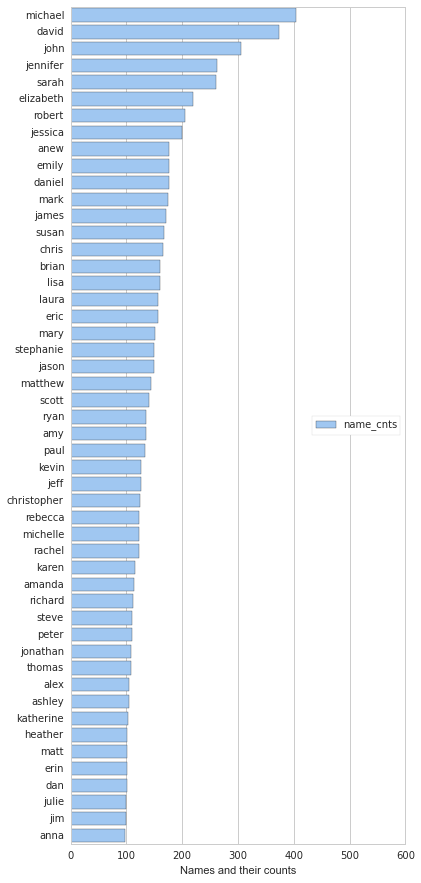

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="name_cnts", y="names", data=df,
            label="name_cnts", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="center right", frameon=True)
ax.set(xlim=(0, 600), ylabel="",
       xlabel="Names and their counts")
#sns.despine(right=True, top=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="name_cnts", y="names", data=df,
            label="name_cnts", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="center right", frameon=True)
ax.set(xlim=(0, 600), ylabel="",
       xlabel="Names and their counts")
#sns.despine(right=True, top=True)

In [21]:
np_names

array([404, 373, 305, ...,   1,   1,   1])

In [11]:
plt.plot(kind='bar', df['first_name'].value_counts())

SyntaxError: non-keyword arg after keyword arg (<ipython-input-11-07f68b3e4e5d>, line 1)

In [6]:
df['first_name'].nunique()

6622

In [ ]:
df_agg = df.groupby(['gender','first_name']).agg({'counter':sum})

In [ ]:
#group by the first level of the index
g = df_agg['counter'].groupby(level=0, group_keys=False)

In [ ]:
# sort by the count of the first names
g.nlargest(50)

In [80]:
male_names.head()

,name_cnts,names,cum_sum,cum_perc
0,404,michael,404,2.001883
1,373,david,777,3.850156
2,305,john,1082,5.361479
3,262,jennifer,1344,6.659729
4,261,sarah,1605,7.953025


In [133]:
# Names and Value Counts
# Female Names
fname_cnts = females['first_name'].value_counts()
fnames = list(fname_cnts.index)
fname_cnts = list(fname_cnts)
fem_names = pd.DataFrame({'names':fnames,'name_cnts':fname_cnts})
fem_names['cum_sum'] = fem_names.name_cnts.cumsum()
fem_names['cum_perc'] = 100*fem_names.cum_sum/fem_names.name_cnts.sum()
fem_names['id'] = np.arange(1, (len(fem_names)+1))
#bins = np.linspace(0, fem_names.cum_perc.max(), 10)
bins = [0, 20, 40, 60, 80]
fem_names['np_ind'] = fem_names['cum_perc'].apply(lambda x: np.digitize(x, bins))

labels = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-90','90+']

fem_names['bins'] = pd.cut(fem_names['cum_perc'], bins, right=True, include_lowest=False)
fem_names['labels'] = pd.cut(fem_names['cum_perc'], bins, labels=labels, right=True, include_lowest=False)


#pandas.cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False)

In [138]:
sizes = list(fem_names.bins.value_counts())
lables 

In [224]:
bins = [0, 20, 40, 60, 80, 90]
fem_names['np_ind'] = fem_names['cum_perc'].apply(lambda x: np.digitize(x, bins))

In [225]:
name_bins = fem_names.np_ind.value_counts().values
name_bins
type(name_bins)

numpy.ndarray

In [226]:
# Percent of names in each of the five bins
name_pcts = 100 * np.sort(name_bins)/np.sum(name_bins)
name_pcts

array([  0.67272116,   1.64816683,   4.9445005 ,  20.85435587,
        34.07332661,  37.80692903])

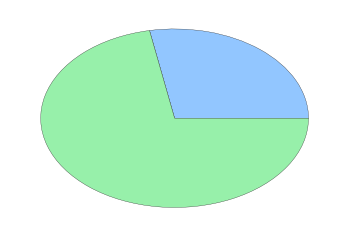

In [223]:
sizes = [28, 72]
labels = ['80%(8,936)', '20%(2,298)']
_= plt.pie(sizes)

In [222]:
11234 - 8936

2298

In [220]:
fem_names.groupby(['np_ind']).agg({'cum_perc':max})

,cum_perc
np_ind,
1,19.672423
2,39.896742
3,59.996439
4,79.989318
5,100.000000


In [216]:
fem_names.groupby(['np_ind']).agg({'cum_sum':max})

,cum_sum
np_ind,
1,2210
2,4482
3,6740
4,8986
5,11234


In [217]:
fem_names.groupby(['np_ind']).agg({'name_cnts':sum})

,name_cnts
np_ind,
1,2210
2,2272
3,2258
4,2246
5,2248


In [218]:
fem_names.groupby(['np_ind']).agg({'id':max})

,id
np_ind,
1,20
2,69
3,216
4,836
5,2973


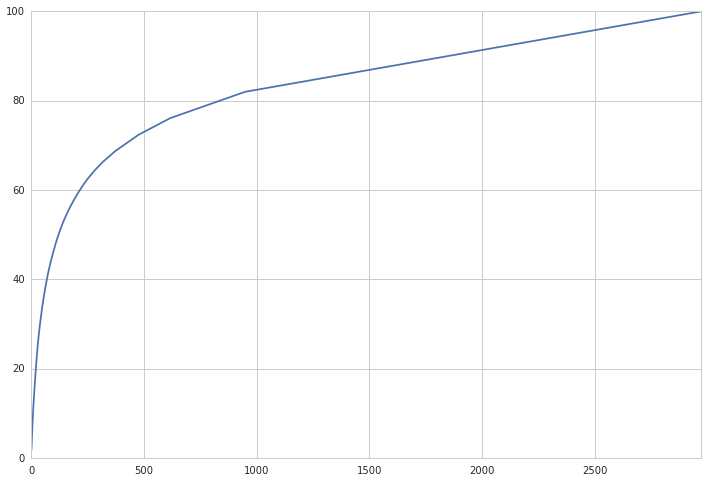

In [213]:
# Plot of name_cnts vs. profiles: Cumsum of Profiles per name
plt.figure();

fem_names['cum_perc'].plot(figsize=(12,8))



In [154]:
fem_names.describe().T

,count,mean,std,min,25%,50%,75%,max
name_cnts,2973,3.778675,11.431556,1.00000,1.000000,1.000000,2.000000,200
cum_sum,2973,9362.571813,1658.990184,200.00000,8802.000000,9748.000000,10491.000000,11234
cum_perc,2973,83.341391,14.767582,1.78031,78.351433,86.772298,93.386149,100
id,2973,1487.000000,858.375501,1.00000,744.000000,1487.000000,2230.000000,2973
np_ind,2973,4.616213,0.717757,1.00000,4.000000,5.000000,5.000000,5


In [152]:
fem_names.head(21)

,name_cnts,names,cum_sum,cum_perc,id,bins,labels,np_ind
0,200,jessica,200,1.780310,1,"(0, 11.111]",10-19,1
1,160,lisa,360,3.204558,2,"(0, 11.111]",10-19,1
2,157,laura,517,4.602101,3,"(0, 11.111]",10-19,1
3,149,stephanie,666,5.928432,4,"(0, 11.111]",10-19,1
4,123,rebecca,789,7.023322,5,"(0, 11.111]",10-19,1
5,123,michelle,912,8.118213,6,"(0, 11.111]",10-19,1
6,114,amanda,1026,9.132989,7,"(0, 11.111]",10-19,1
7,110,steve,1136,10.112160,8,"(0, 11.111]",10-19,1
8,103,katherine,1239,11.029019,9,"(0, 11.111]",10-19,1
9,100,julie,1339,11.919174,10,"(11.111, 22.222]",20-29,1


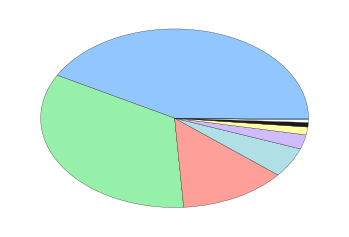

In [141]:
# Pie Chart of Names vs Counts

#sizes = [215, 130, 245, 210]
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode = (0.1, 0, 0, 0)  # explode 1st slice
 
# Plot
# plt.pie(sizes, explode=explode, labels=labels, colors=colors,
#         autopct='%1.1f%%', shadow=True, startangle=140)

_= plt.pie(sizes)

# labels of the pie chart:
# Percentage of Profiles with the top 20% names (9)
# Labels: 20% Names, 40% names, 
# Data: % profiles corresponding to the labels

# Chart 2: Bar Chart of the Top 10 Male Names and Top 10 Female Names in one chart

# Chart 3: 


In [101]:
bins = np.linspace(fem_names.cum_perc.min(), fem_names.cum_perc.max(), 10)
groups = fem_names.groupby(np.digitize(fem_names.cum_perc, bins))

In [142]:
groups

In [112]:
np.arange(1, (len(fem_names)))

array([   1,    2,    3, ..., 2970, 2971, 2972])

In [78]:
fem_names['id'] = np.arange(len(fem_names))

In [ ]:
## Create Bins for the Pie Chart

## Need to create 

df = pandas.DataFrame({"a": np.random.random(100),
                       "b": np.random.random(100),
                       "id": np.arange(100)})

bins = np.linspace(fem_names.cum_perc.min(), fem_names.cum_perc.max(), 20)
groups = fem_names.groupby(np.digitize(fem_names.cum_perc, bins))


In [91]:
fem_names.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2973 entries, 0 to 2972
Data columns (total 4 columns):
name_cnts    2973 non-null int64
names        2973 non-null object
cum_sum      2973 non-null int64
cum_perc     2973 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 116.1+ KB


In [92]:
2973/10

297.3

In [79]:
# Male Names
mname_cnts = males['first_name'].value_counts()
mnames = list(mname_cnts.index)
mname_cnts = list(mname_cnts)
male_names = pd.DataFrame({'names':mnames,'name_cnts':mname_cnts})

male_names['cum_sum'] = male_names.name_cnts.cumsum()
male_names['cum_perc'] = 100*male_names.cum_sum/male_names.name_cnts.sum()

#type(f_names)

In [ ]:
## Plot a Pie Chart

# The slices will be ordered and plotted counter-clockwise.

bins = np.linspace(fem_names.cum_perc.min(), fem_names.cum_perc.max(), 20)
groups = fem_names.groupby(np.digitize(fem_names.cum_perc, bins))

labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
sizes = [15, 30, 45, 10]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)


# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')

fig = plt.figure()
ax = fig.gca()

# Data to plot
labels = 'Python', 'C++', 'Ruby', 'Java'
sizes = [215, 130, 245, 210]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
    
plt.axis('equal')
plt.show()
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Sunny", "Cloudy"])
ax.set_yticklabels(["Dry", "Rainy"])
ax.set_xlim((-0.5, 1.5))
ax.set_ylim((-0.5, 1.5))

# Set aspect ratio to be equal so that pie is drawn as a circle.
ax.set_aspect('equal')

plt.show()

In [81]:
# fig, ax = plt.subplots()
# f_names.plot(ax=ax, kind='bar', alpha = 0.5, figsize=(12,8))

In [8]:
females['first_name'].nunique()

2973

In [9]:
males['first_name'].nunique()

3649

In [ ]:
set(males['first_name'])

In [ ]:
# unique names in females and males
print (females_all['first_name'].nunique())
print (males_all['first_name'].nunique())

In [ ]:
x = zip(fnames, gender_fnames1)
with open('gender1000.txt', 'w') as f:
    for line in x:
        name = line[0]
        g = line[1]
        nameg = name + "," + g + "\n"
        f.write(nameg)
        #f.write("\n")

In [ ]:
letter_freq = df.last_letter.value_counts()
letter_freq.sort_values(ascending=False, inplace=True)


In [ ]:
# Plot one of the features for gender prediction: last letter
fig, ax = plt.subplots()
letter_freq.plot(ax=ax, kind='bar', alpha = 0.5, figsize=(12,8))

In [85]:
df1 = pd.DataFrame({'A' : ['one', 'one', 'two', 'three'] * 3,
                   'B' : np.random.randn(12)})
bins = {'one': (-10,-1,0,1,10), 'two':(-100,0,100), 'three':(-999,0,1,2,3)}

def func(row):
    return pd.cut([row['B']], bins=bins[row['A']])[0]

df1['C'] = df1.apply(func, axis=1)

In [89]:
def binize2(df):
    df['C'] = ''
    for key, values in bins.items():
        mask = df['A'] == key
        df.loc[mask, 'C'] = pd.cut(df.loc[mask, 'B'], bins=values)
    return df

df1 = binize2(df1)

In [90]:
df1

,A,B,C
0,one,0.632204,"(0, 1]"
1,one,-0.621930,"(-1, 0]"
2,two,-0.628475,"(-100, 0]"
3,three,0.219689,"(0, 1]"
4,one,0.528992,"(0, 1]"
5,one,1.064517,"(1, 10]"
6,two,1.232378,"(0, 100]"
7,three,0.312443,"(0, 1]"
8,one,-2.029465,"(-10, -1]"
9,one,-0.531574,"(-1, 0]"


# Practicing Plots

In [143]:
df4 = pd.DataFrame({'a': np.random.randn(1000) + 1, 'b': np.random.randn(1000), 'c': np.random.randn(1000) - 1}, columns=['a', 'b', 'c'])

In [144]:
plt.figure();


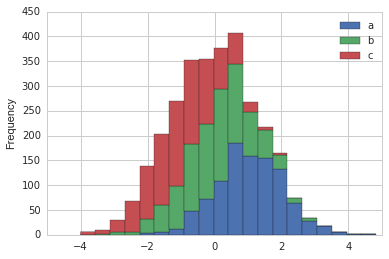

In [145]:
df4.plot(kind='hist', stacked=True, bins=20)

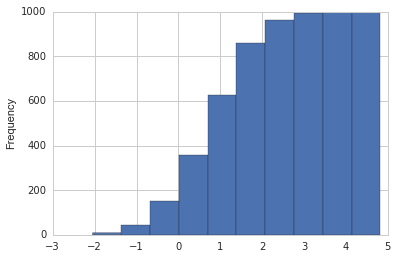

In [146]:
df4['a'].plot(kind='hist', cumulative=True)

In [227]:
43/72

0.5972222222222222